In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import metrics
from itertools import product
from scipy.linalg import pinv
import warnings
import time
from collections import defaultdict
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
results=[['Precision', 'Recall', 'Accuracy', 'Balanced Accuracy','Time']]

In [2]:
#import data
cancer_df = pd.read_csv('/Users/qingzhou/Desktop/GT_OMSCS/Machine_Learning_CS7641/assignment_1/breast-cancer-wisconsin.data'
                        ,names = ['id', 'thickness', 'uniform_size', 'uniform_shape', 'adhesion', 'single_cell_size'
                                                          , 'nuclei', 'chromatin', 'normal_nucleoli', 'mitoses', 'Diagnosis'])
#change class to 0 and 1
cancer_df['Diagnosis'].mask(cancer_df['Diagnosis'] == 2, 0, inplace= True)
cancer_df['Diagnosis'].mask(cancer_df['Diagnosis'] == 4, 1, inplace= True)
#replace missing values
#cancer_df.isnull().sum()
#get mean value in nuclei
# print(cancer_df.replace('?', np.NaN).mean(skipna= True))
#print(cancer_df[cancer_df['nuclei'].isnull()])
#replace ? with 3 
cancer_df['nuclei'].mask(cancer_df['nuclei']== '?', 3, inplace = True)
# print(cancer_df[cancer_df['nuclei']=='?'])
#remove id from data point

cancer_df = cancer_df[['thickness', 'uniform_size', 'uniform_shape', 'adhesion', 'single_cell_size'
                                                          , 'nuclei', 'chromatin', 'normal_nucleoli', 'mitoses', 'Diagnosis']]
#x and y dataset
x_features = ['thickness', 'uniform_size', 'uniform_shape', 'adhesion', 'single_cell_size'
                                                          , 'nuclei', 'chromatin', 'normal_nucleoli', 'mitoses']
y_output = ['Diagnosis']
df_x = cancer_df[x_features]
df_y = cancer_df[y_output]
class_name = ['Benign', 'Malignant']


In [3]:
def prediction(pred, y):
    return metrics.precision_score(y, pred), metrics.recall_score(y, pred), metrics.accuracy_score(y, pred), metrics.confusion_matrix(y, pred), metrics.balanced_accuracy_score(y, pred)

In [21]:
def learning(model, x, y, folds, model_name):
    
    size, train, val, fit, _ = learning_curve(model, x, y, cv=folds, return_times=True)
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.grid(False)
    axes[0].set_title('Learning Curve of ' + model_name)
    axes[0].set_xlabel("Training Number")
    axes[0].set_ylabel("Accuracy")
#     print(train)
#     print(val)
    train_mean = np.mean(train, axis=1)
    train_std = np.std(train, axis=1)
    val_mean = np.mean(val, axis=1)
    val_std = np.std(val, axis=1)
    fit_mean = np.mean(fit, axis=1)
    fit_std = np.std(fit, axis=1)
    axes[0].grid()
    axes[0].fill_between(
        size,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.1,
        color="darkorange",
    )
    axes[0].fill_between(
        size,
        val_mean - val_std,
        val_mean + val_std,
        alpha=0.1,
        color="navy",
    )
    axes[0].plot(
        size, train_mean, "o-", color="darkorange", label="Training Accuracy"
    )
    axes[0].plot(
        size, val_mean, "o-", color="navy", label="Cross-validation Accuracy"
    )
    axes[0].legend(loc="best")
    # Plot n_samples vs fit_times
    plt.grid(False)
    axes[1].grid()
    axes[1].plot(size, fit_mean, "o-")
    axes[1].fill_between(
        size,
        fit_mean - fit_std,
        fit_mean + fit_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training Number")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the "+ model_name)

    # Plot fit_time vs score
    fit_argsort = fit_mean.argsort()
    fit_sorted = fit_mean[fit_argsort]
    val_mean_sorted = val_mean[fit_argsort]
    val_std_sorted = val_std[fit_argsort]
    plt.grid(False)
    axes[2].grid()
    axes[2].plot(fit_sorted, val_mean_sorted, "o-")
    axes[2].fill_between(
        fit_sorted,
        val_mean_sorted - val_std_sorted,
        val_mean_sorted + val_std_sorted,
        alpha=0.1,
    )
    plt.grid(False)
    axes[2].set_xlabel("Fit Times")
    axes[2].set_ylabel("Accuracy")
    axes[2].set_title("Performance of the "+ model_name)

In [142]:
def nn(x,y, x_test, y_test, reduce_x, dy):
    
    model = MLPClassifier(n_iter_no_change = 50, learning_rate_init=1e-3, hidden_layer_sizes=(10,1), random_state=0, activation='logistic')
#     loss_train = model.loss_curve_
    learning(model, reduce_x, dy, 5, 'Neural Network')
    
    model.fit(x_test,y_test)
    loss_val = model.loss_curve_
    start = time.time()
    model.fit(x,y)
    wall_time = time.time() - start
    loss_train = model.loss_curve_
#     print(loss_values)
#     print(model.n_layers_)
#     plt.plot(nn_output)
    pred = model.predict(x_test)
    pre, rec, acc, mtx, bacc = prediction(pred, y_test)
    print('Precision: ',  pre)
    print('Recall: ',  rec)
    print('Accuracy: ',  acc)
    print('Balanced Accuracy: ', bacc)
    print(mtx)
    print('Wall time: ', wall_time)
    results.append([pre, rec, acc, bacc, wall_time])
    metrics.plot_confusion_matrix(model, x_test, y_test)
    plt.grid(False)
    return [loss_train, loss_val]
#     return loss_val

In [23]:
def plotting(labels, data, rang, x, y, title, file):
    plt.figure()
    for label, arr in zip(labels, data):
        plt.plot(rang, arr, label=label)
    plt.legend()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
#     plt.savefig(file, dpi = 1200)

In [66]:
def kmean(x, y, rang, file):
    output = []
    for k in rang:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(x)
        output.append(kmeans.inertia_)
    plotting(['kmean'], [output], rang, 'K clusters', 'Sum of Squared Error','Kmean Sum of Squared Error (Cancer)' , file )
#         print(k)

In [67]:
def dkmean(x, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(x)
    return kmeans.labels_

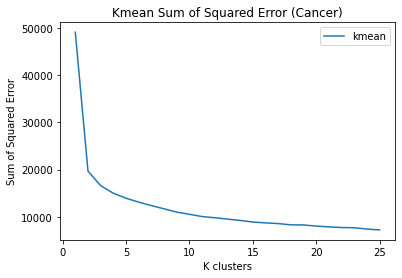

In [68]:
kmean(df_x,df_y, [i for i in range(1,26)], 'kmean-sse')

In [87]:
def sil(range_n_clusters, X, km, title):
    if km:
        cluster = KMeans(n_clusters=range_n_clusters, random_state=0)
    else:
        cluster = GaussianMixture(n_components=range_n_clusters, covariance_type='full')
    cluster_labels = cluster.fit_predict(X)
    for n_clusters in [range_n_clusters]:
        fig, (ax1) = plt.subplots(1)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = metrics.silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  

        ax1.set_title("The Silhouette Plot for the "+title +'(Cancer)' )
        ax1.set_xlabel("The Silhouette Coefficient Values")
        ax1.set_ylabel("Cluster Label")
        ax1.axvline(x=silhouette_avg, color="orange", linestyle="--")

        ax1.set_yticks([])  
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


In [130]:
def cluster_plot(k, x, idx1, idx2):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(x)
    nodes = kmeans.cluster_centers_
    label = kmeans.predict(x)
    plt.scatter(x.to_numpy()[:,idx1], x.to_numpy()[:,idx2], marker=".", s=50, lw=2, c=label)
    plt.scatter(
        nodes[:, idx1],
        nodes[:, idx2],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k"
    )
    for i, n in enumerate(nodes):
        plt.scatter(n[idx1], n[idx2], marker="$%d$" % i, alpha=1, s=100)

    plt.title("KMean Clustering (Cancer)")
    plt.xlabel("Feature space for the " +str(idx1)+ " feature")
    plt.ylabel("Feature space for the "+str(idx2)+" feature")


For n_clusters = 2 The average silhouette_score is : 0.5957711153433957
For n_clusters = 3 The average silhouette_score is : 0.5234877075811751
For n_clusters = 4 The average silhouette_score is : 0.5360394065853743
For n_clusters = 5 The average silhouette_score is : 0.2603599554667864
For n_clusters = 6 The average silhouette_score is : 0.25922925214232284
For n_clusters = 7 The average silhouette_score is : 0.2569818138782918
For n_clusters = 8 The average silhouette_score is : 0.25588760450170944
For n_clusters = 9 The average silhouette_score is : 0.24876250873472877
For n_clusters = 10 The average silhouette_score is : 0.2531868792100909
For n_clusters = 11 The average silhouette_score is : 0.2485356828405686
For n_clusters = 12 The average silhouette_score is : 0.254579480652741
For n_clusters = 13 The average silhouette_score is : 0.25740171010454893
For n_clusters = 14 The average silhouette_score is : 0.25412014227052054
For n_clusters = 15 The average silhouette_score is : 0

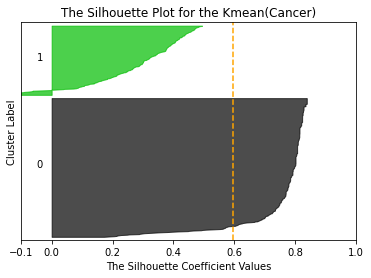

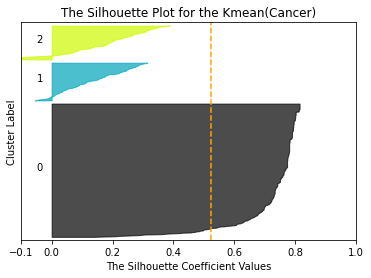

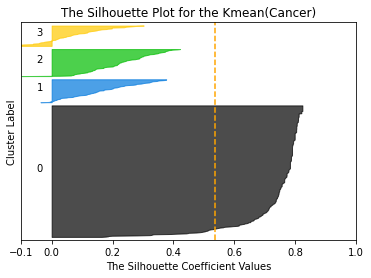

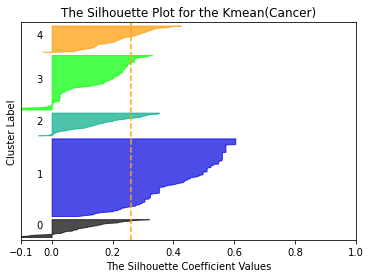

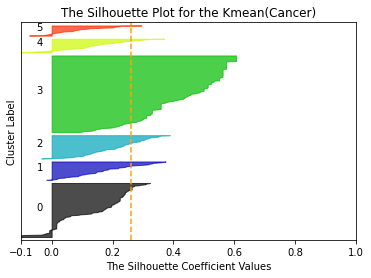

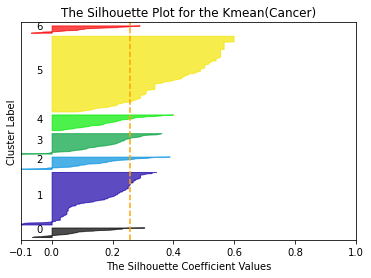

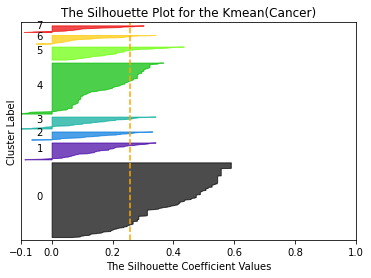

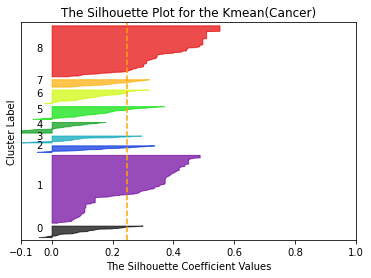

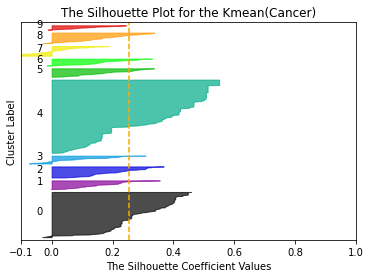

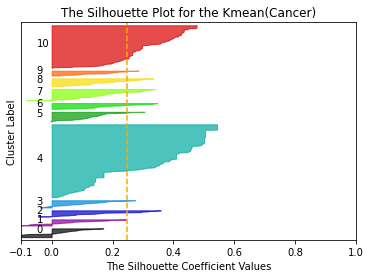

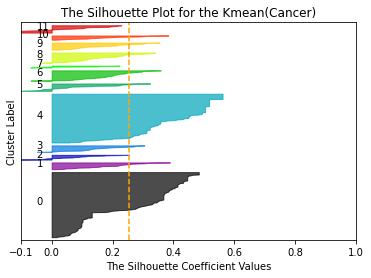

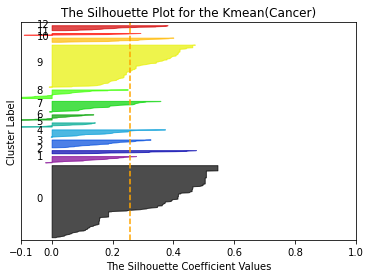

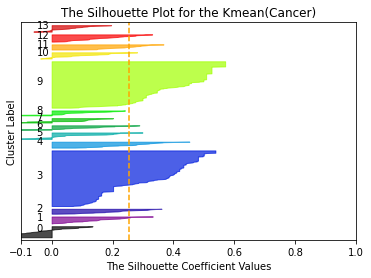

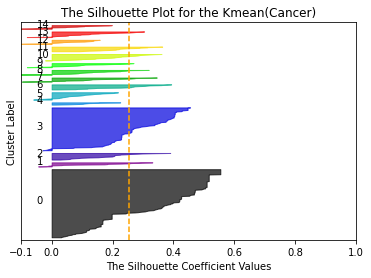

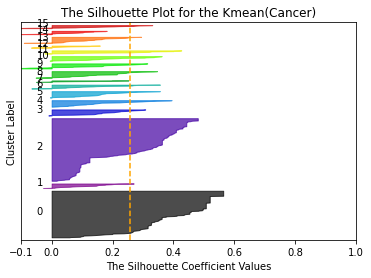

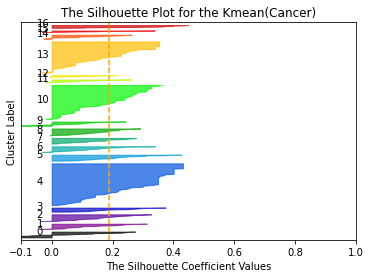

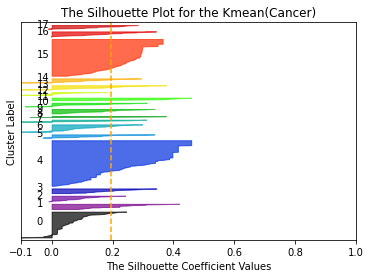

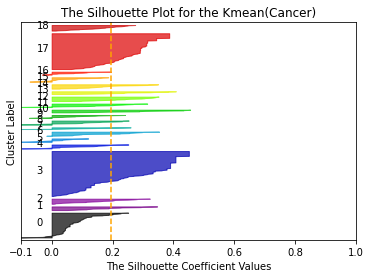

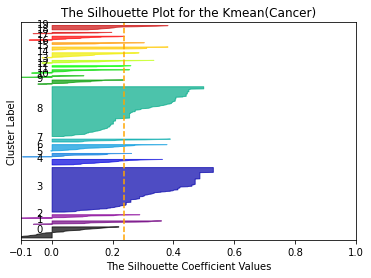

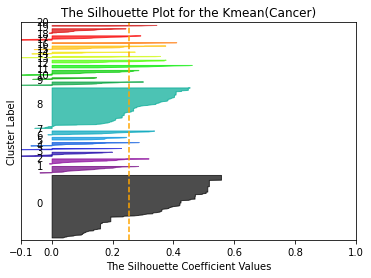

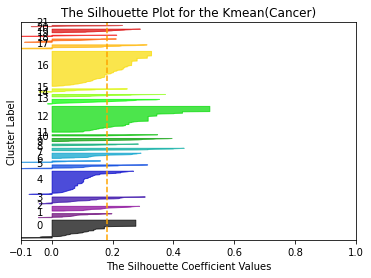

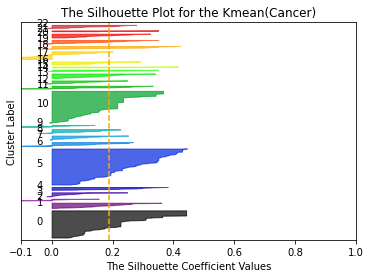

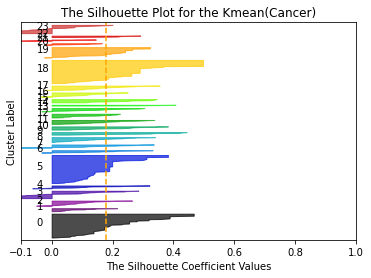

In [88]:
for i in range(2,25):
    sil(i, df_x, True, 'Kmean')

In [72]:
prediction(dkmean(df_x,2),df_y)

(0.9527896995708155,
 0.921161825726141,
 0.9570815450643777,
 array([[447,  11],
        [ 19, 222]]),
 0.9485721792386164)

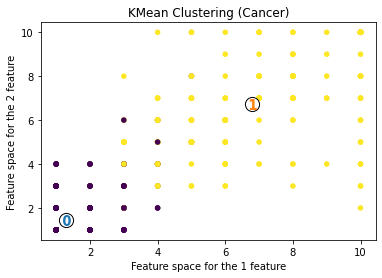

In [131]:
cluster_plot(2, df_x, 1, 2)

In [75]:
def em(x, y, rang, file):
    output = [[0 for i in range(25)] for j in range(4)]
    covar = ['full', 'tied', 'diag', 'spherical']
    for k in rang:
        for i, c in enumerate(covar):
            EM = GaussianMixture(n_components=k, random_state=0, covariance_type=c)
            EM.fit(x)
            output[i][k-1] = EM.score(x)
#             print(EM.converged_)
    plotting(covar, output, rang, 'Number of Components', 'Log-likelihood ', 'Expectation Maximization (Cancer)', file)
        

In [76]:
def dem(x, k):
    EM = GaussianMixture(n_components=k, random_state=0, covariance_type='full')
    EM.fit(x)
    return EM.predict(x)

In [77]:
def combine(x1, x2):
    x1 = pd.DataFrame(x1)
    x1['new_feature'] = x2
    return x1

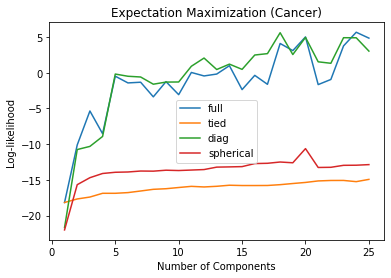

In [78]:
em(df_x, df_y, [i for i in range(1,26)], 'EM-LL')

For n_clusters = 2 The average silhouette_score is : 0.5957711153433957
For n_clusters = 3 The average silhouette_score is : 0.5234877075811751
For n_clusters = 4 The average silhouette_score is : 0.5360394065853743
For n_clusters = 5 The average silhouette_score is : 0.2603599554667864
For n_clusters = 6 The average silhouette_score is : 0.25922925214232284
For n_clusters = 7 The average silhouette_score is : 0.2569818138782918
For n_clusters = 8 The average silhouette_score is : 0.25588760450170944
For n_clusters = 9 The average silhouette_score is : 0.24876250873472877
For n_clusters = 10 The average silhouette_score is : 0.2531868792100909
For n_clusters = 11 The average silhouette_score is : 0.2485356828405686
For n_clusters = 12 The average silhouette_score is : 0.254579480652741
For n_clusters = 13 The average silhouette_score is : 0.25740171010454893
For n_clusters = 14 The average silhouette_score is : 0.25412014227052054
For n_clusters = 15 The average silhouette_score is : 0

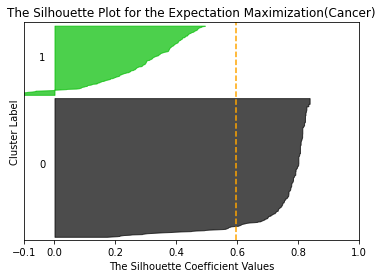

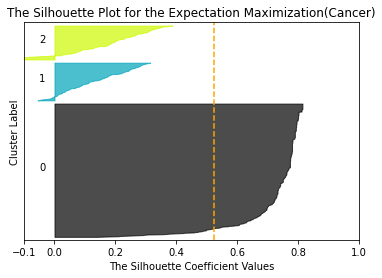

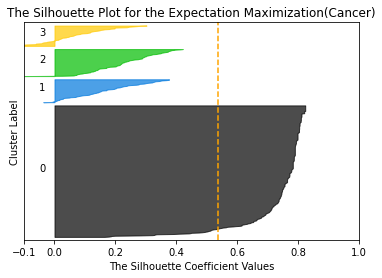

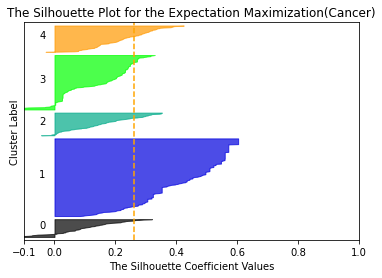

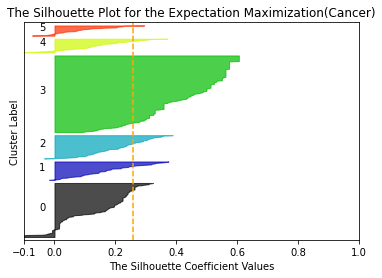

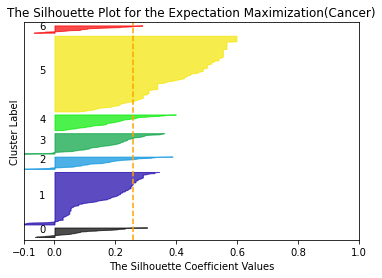

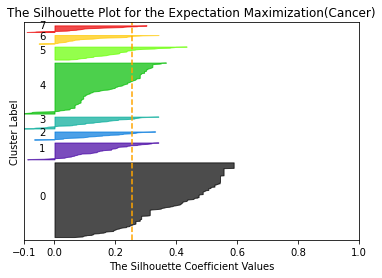

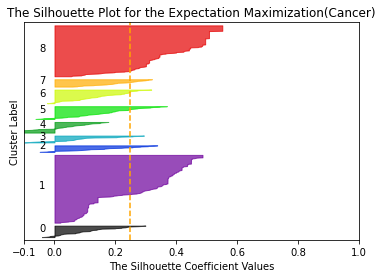

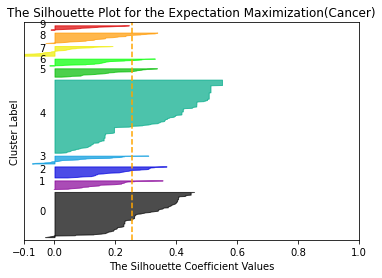

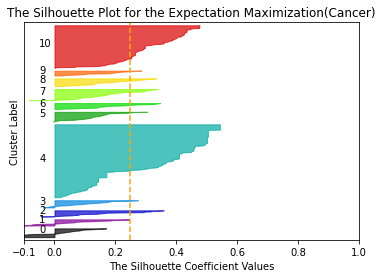

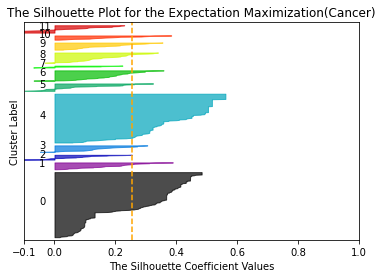

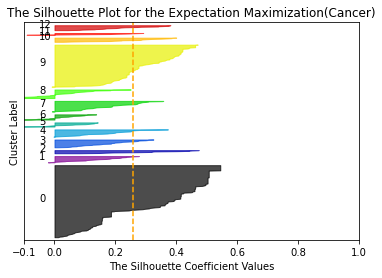

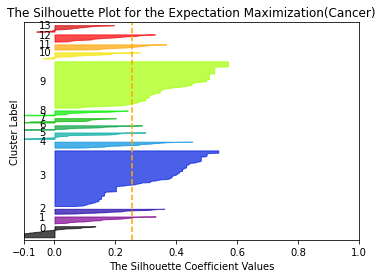

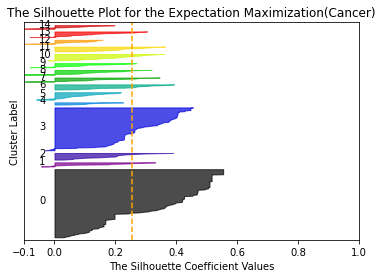

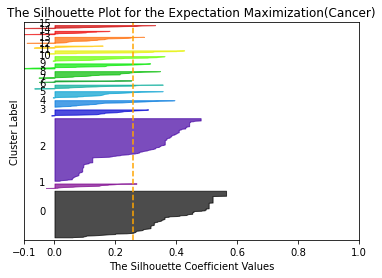

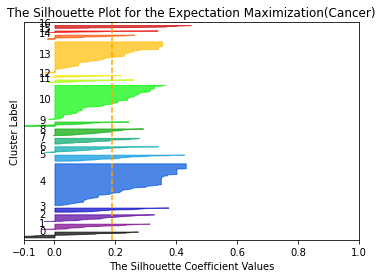

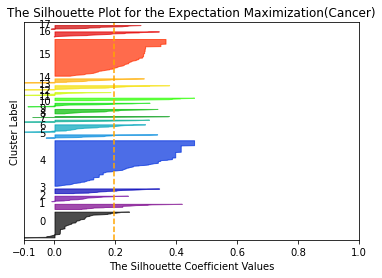

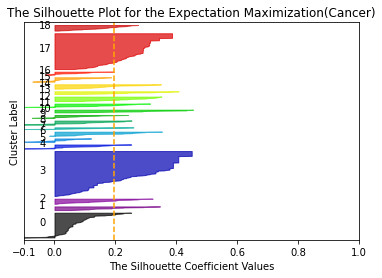

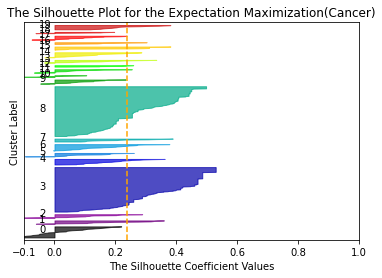

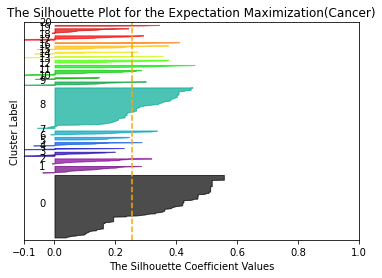

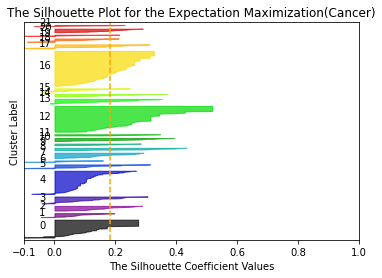

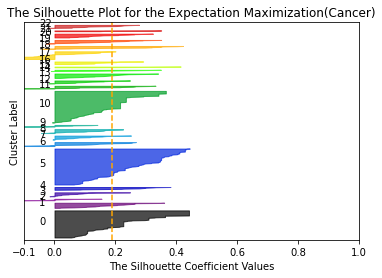

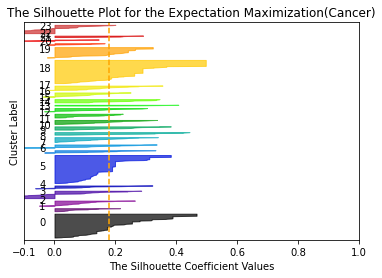

In [89]:
for i in range(2,25):
    sil(i, df_x, False, 'Expectation Maximization')
    

In [80]:
prediction(dem(df_x,2), df_y)

(0.8191126279863481,
 0.995850622406639,
 0.9227467811158798,
 array([[405,  53],
        [  1, 240]]),
 0.9400650491945859)

In [143]:
def pc(x, y, rang, file, cancer):
    pca = PCA( random_state=0)
    pca.fit(x)
    output = pca.explained_variance_ratio_
    plotting(['PCA'], [output], [i for i in range(len(output))],'Component Number', 'Variance Ratio', 'PCA Plot(Cancer)', file)
    reduce_x = PCA(n_components = 2).fit_transform(x)
    print(reduce_x,reduce_x.shape,'features')
    kmean(reduce_x,y, [i for i in range(1,26)], 'pca-kmean-sse')
    em(reduce_x, y, [i for i in range(1,26)], 'pca-EM-LL')
    
    for i in range(2,5):
        sil(i, reduce_x, True, 'PCA-Kmean')
        sil(i, reduce_x, False, 'PCA-EM')
    if cancer:
        X_train, X_test, Y_train, Y_test = train_test_split(reduce_x, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, reduce_x, y)
        new_x2 = dkmean(reduce_x, 2)
        new_x3 = dem(reduce_x, 2)
        x2 = combine(reduce_x, new_x2)
        x3 = combine(reduce_x, new_x3)
        X_train, X_test, Y_train, Y_test = train_test_split(x2, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, x2, y)
        X_train, X_test, Y_train, Y_test = train_test_split(x3, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, x3, y)

[[-4.43744528  0.08478549]
 [ 4.82960807 -4.82210776]
 [-4.59662131 -0.58699201]
 ...
 [10.33355456  7.22086981]
 [ 6.45495253  2.48301601]
 [ 7.54557404  1.1480077 ]] (699, 2) features
For n_clusters = 2 The average silhouette_score is : 0.741536811240111
For n_clusters = 2 The average silhouette_score is : 0.741536811240111
For n_clusters = 3 The average silhouette_score is : 0.6790051616615911
For n_clusters = 3 The average silhouette_score is : 0.6790051616615911
For n_clusters = 4 The average silhouette_score is : 0.7007585179152543
For n_clusters = 4 The average silhouette_score is : 0.7007585179152543
Precision:  0.0
Recall:  0.0
Accuracy:  0.6428571428571429
Balanced Accuracy:  0.5
[[90  0]
 [50  0]]
Wall time:  0.15375494956970215
Precision:  0.9512195121951219
Recall:  0.9512195121951219
Accuracy:  0.9714285714285714
Balanced Accuracy:  0.9655087459965508
[[97  2]
 [ 2 39]]
Wall time:  0.1582050323486328
Precision:  0.9803921568627451
Recall:  1.0
Accuracy:  0.992857142857142

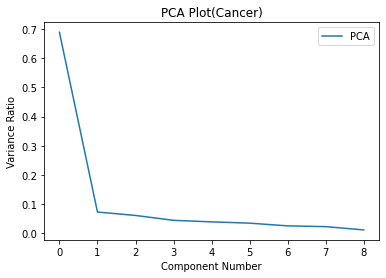

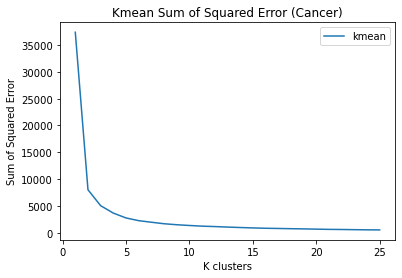

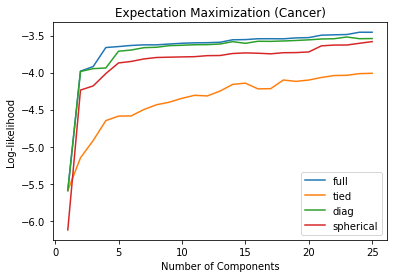

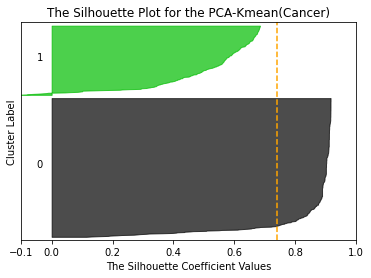

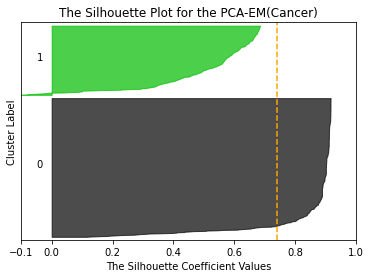

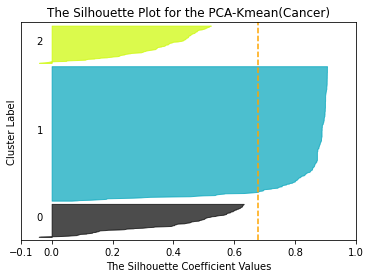

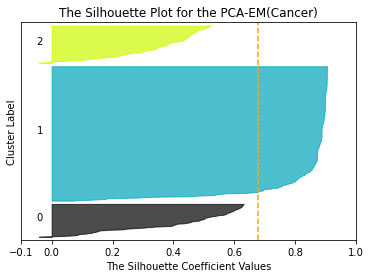

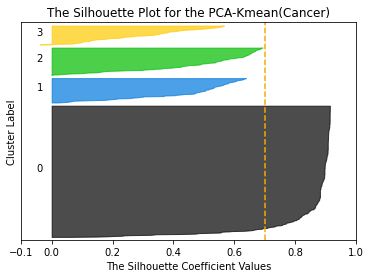

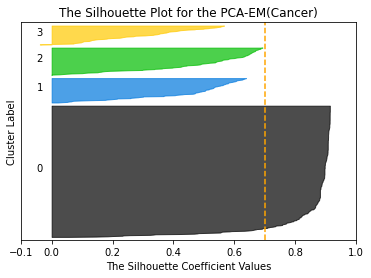

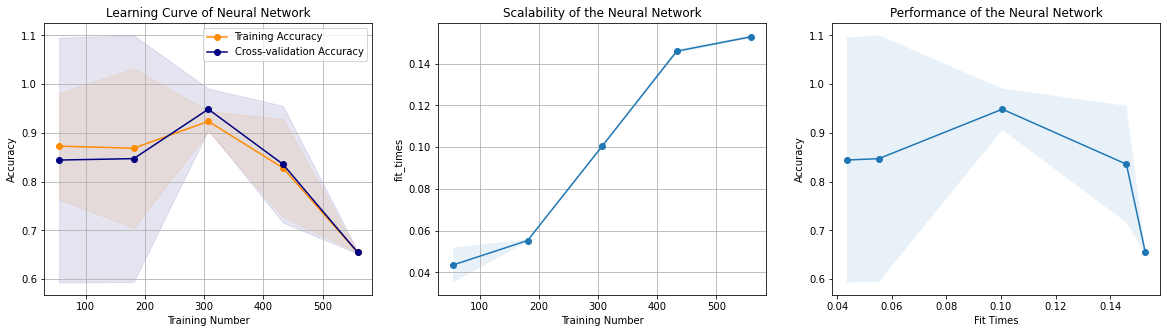

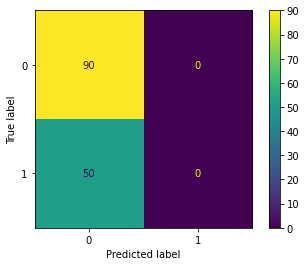

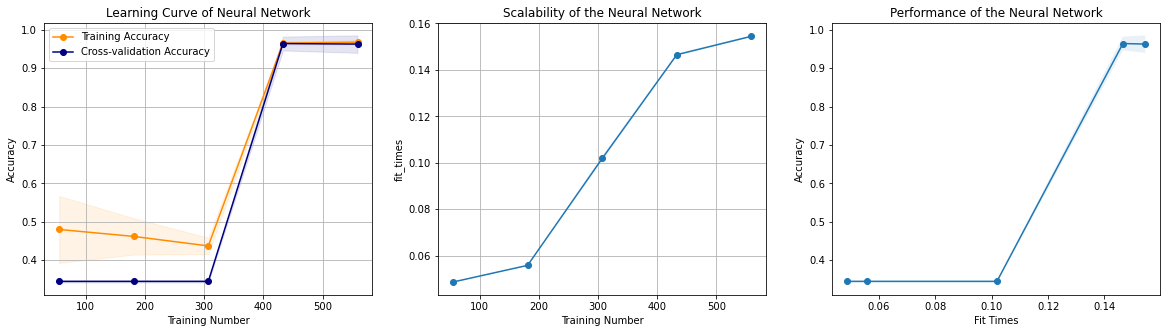

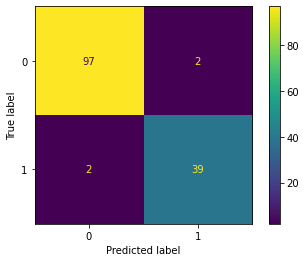

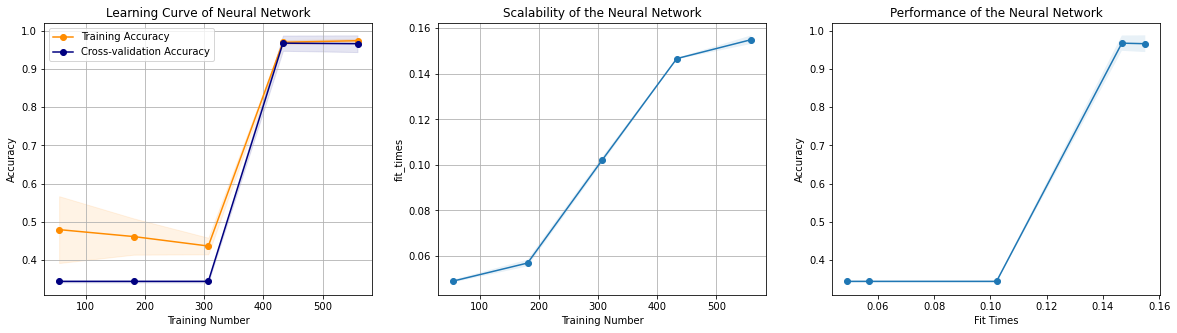

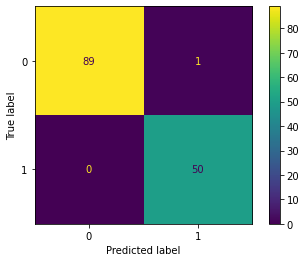

In [144]:
pc(df_x, df_y, None ,'pca', True)


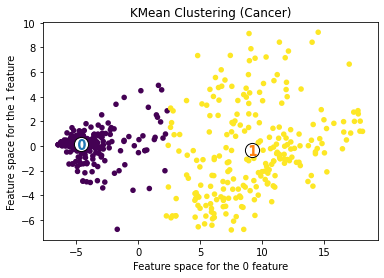

In [132]:
reduce_x = PCA(n_components = 2).fit_transform(df_x)
cluster_plot(2, pd.DataFrame(reduce_x), 0, 1)

In [145]:
def ic(x, y, rang, file, cancer):
    kurt = []
    for i in rang:
        ica = FastICA(n_components=i, random_state=0)
        temp = ica.fit_transform(x)
        kurt.append(pd.DataFrame(temp).kurt(axis=0).abs().mean())
    plotting(['ICA'], [kurt], rang, 'Component Number', 'Normalized Kurtosis Value', 'ICA Kurtosis Value(Cancer)', file)
   
    ica = FastICA(n_components=kurt.index(max(kurt)) + 1, random_state=0)
    reduce_x= ica.fit_transform(x)
    print(reduce_x,reduce_x.shape,'features')
    
    kmean(reduce_x,y, [i for i in range(1,26)], 'ICA-kmean-sse')
    em(reduce_x, y, [i for i in range(1,26)], 'ICA-EM-LL')
    for i in range(2,9):
        sil(i, reduce_x, True, 'ICA-Kmean')
        sil(i, reduce_x, False, 'ICA-EM')
    if cancer:
        X_train, X_test, Y_train, Y_test = train_test_split(reduce_x, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, reduce_x, y)
        new_x2 = dkmean(reduce_x, 2)
        new_x3 = dem(reduce_x, 2)
        x2 = combine(reduce_x, new_x2)
        x3 = combine(reduce_x, new_x3)
        X_train, X_test, Y_train, Y_test = train_test_split(x2, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, x2, y)
        X_train, X_test, Y_train, Y_test = train_test_split(x3, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, x3, y)

[[-0.0190458  -0.00209254 -0.04911449 ...  0.00307122 -0.00184251
   0.00988776]
 [-0.02540261  0.04285217  0.05071668 ... -0.01402981  0.09370809
   0.00318614]
 [-0.01140129 -0.02388944 -0.0202775  ... -0.00061612 -0.00383748
   0.01009665]
 ...
 [ 0.10888532 -0.0566332   0.0355895  ... -0.00426229  0.02066902
   0.04224392]
 [ 0.00847707 -0.12551541  0.00226967 ... -0.05780465 -0.01549703
  -0.01343106]
 [ 0.0023496  -0.12956188  0.0172356  ...  0.00674218  0.02636643
  -0.03375858]] (699, 9) features
For n_clusters = 2 The average silhouette_score is : 0.3260869933988123
For n_clusters = 2 The average silhouette_score is : 0.3260869933988123
For n_clusters = 3 The average silhouette_score is : 0.33898935327300833
For n_clusters = 3 The average silhouette_score is : 0.33898935327300833
For n_clusters = 4 The average silhouette_score is : 0.3492181668184629
For n_clusters = 4 The average silhouette_score is : 0.3492181668184629
For n_clusters = 5 The average silhouette_score is : 0.3

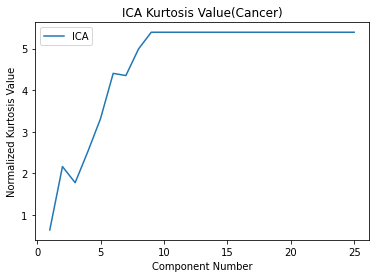

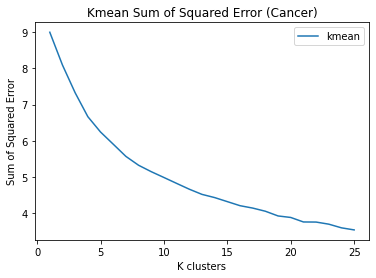

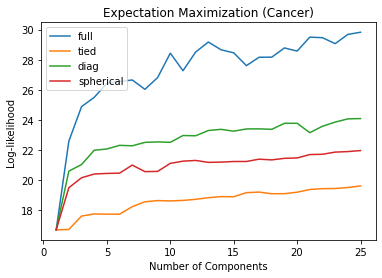

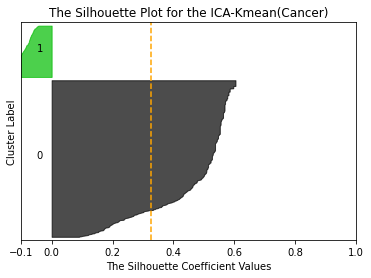

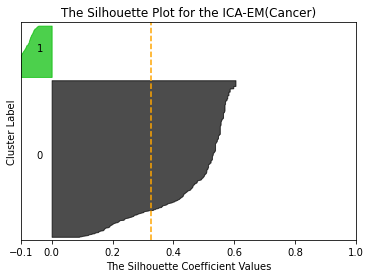

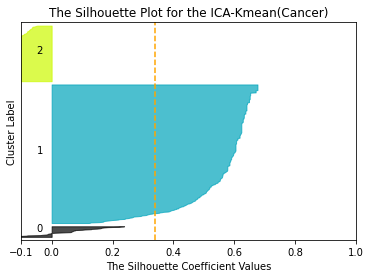

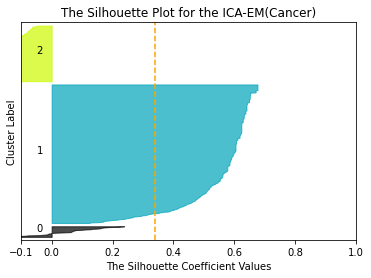

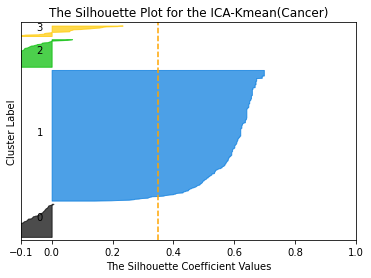

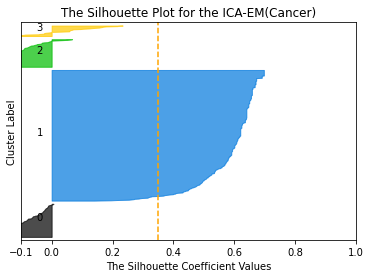

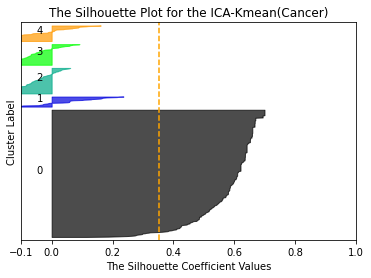

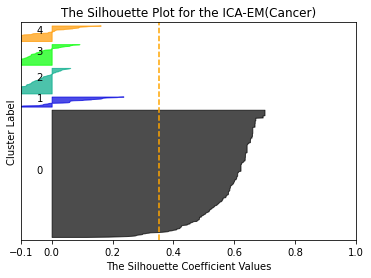

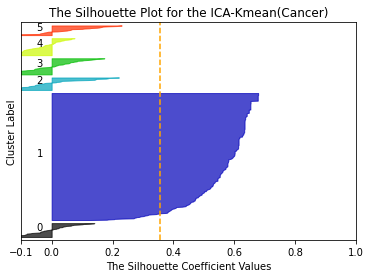

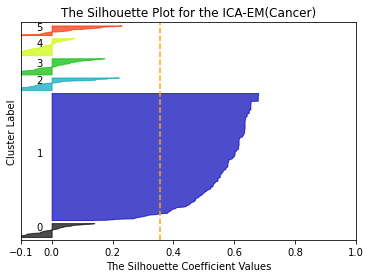

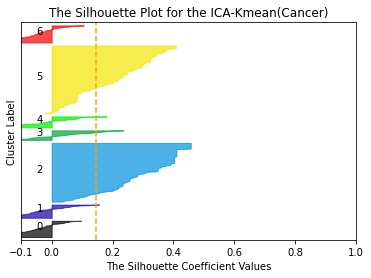

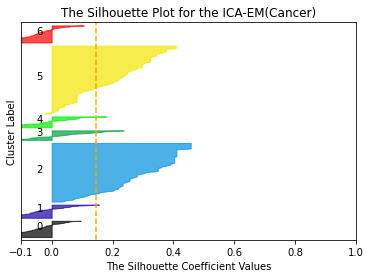

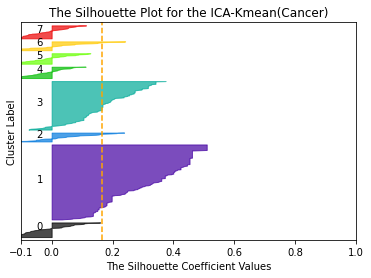

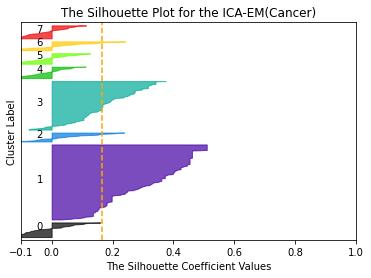

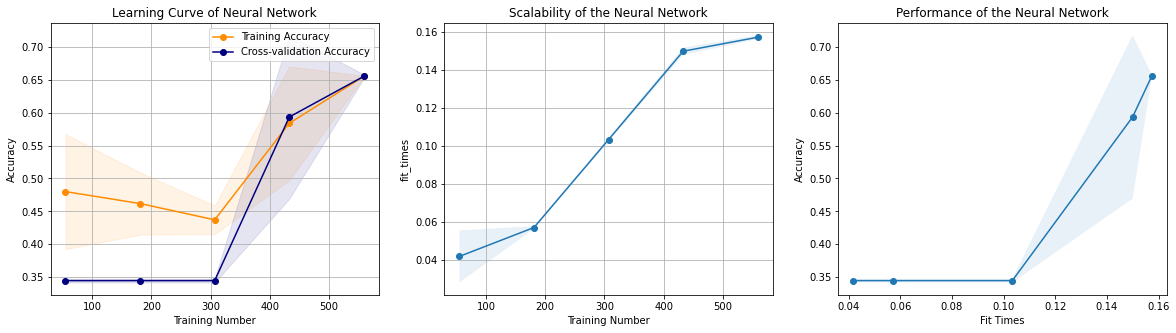

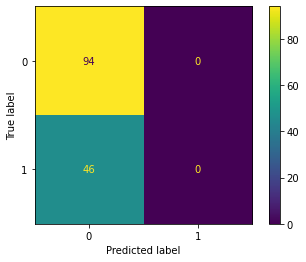

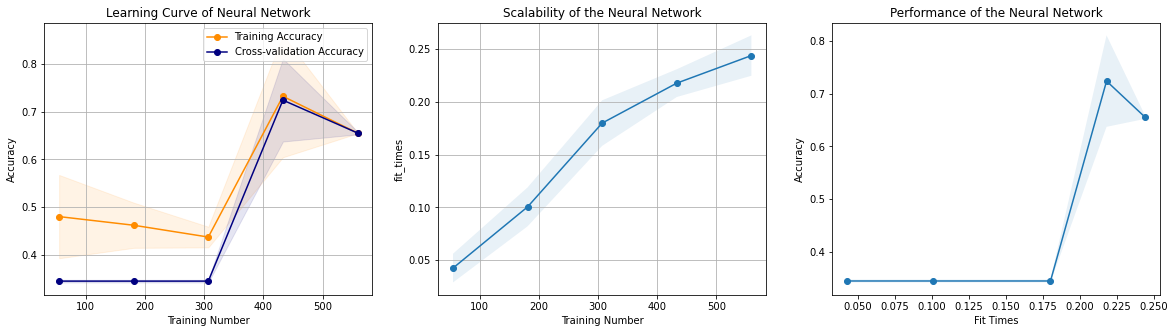

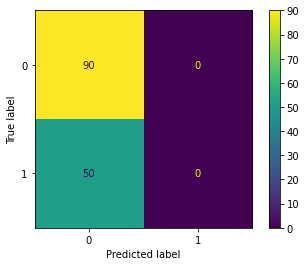

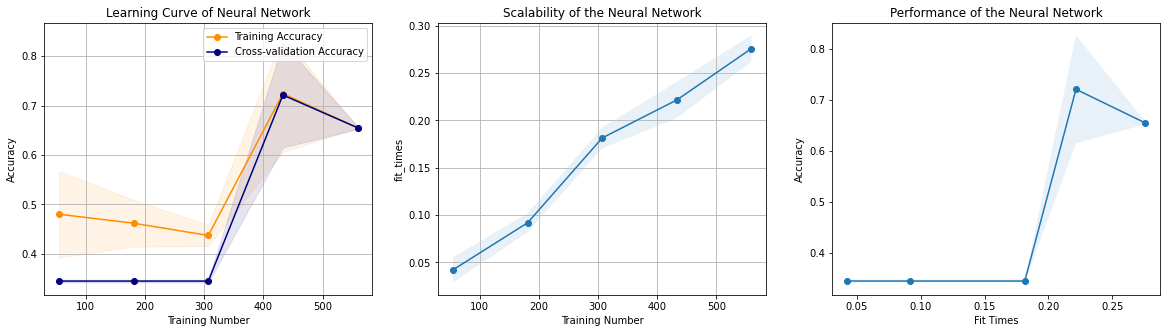

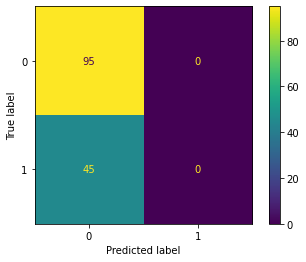

In [146]:
ic(df_x, df_y, [i for i in range(1,26)] ,'ica', True)

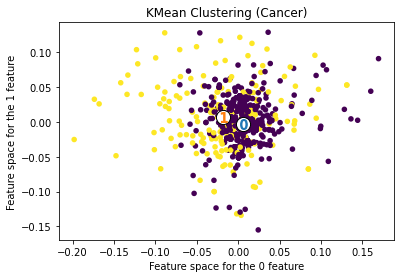

In [136]:
ica = FastICA(n_components=9, random_state=0)
reduce_x= ica.fit_transform(df_x)
cluster_plot(2, pd.DataFrame(reduce_x), 0, 1)

In [147]:
def rd(x, y, rang, file, cancer):
    dic = defaultdict(dict)
    for r, i in product(rang, range(1,10)):
        rda = GaussianRandomProjection(n_components=i, random_state=r)
        reduce_x = rda.fit_transform(x)
        invs = pinv(rda.components_.T)
        recon =reduce_x.dot(invs)
        dic[i][r] = metrics.mean_squared_error(x,recon)
    rec = pd.DataFrame(dic).T
    rec_mean =  rec.mean(axis=1).tolist()
    rec_std = rec.std(axis=1).tolist()
    
    top = []
    bot = []
    zip_object = zip(rec_mean, rec_std)
    for l1, l2 in zip_object:
        top.append(l1 + l2)
        bot.append(l1 - l2)
        
   
    plt.plot(range(1, 10), rec_mean)
    plt.fill_between(range(1, 10), bot, top, alpha=0.2)
    plt.xlabel('Number of Components')
    plt.ylabel('Mean Reconstruction Error')
    plt.grid(False)
    plt.title(file + " Mean Reconstruction Error (Cancer)")
    
    rda = GaussianRandomProjection(n_components=3, random_state=0)
    reduce_x = rda.fit_transform(x)
    print(reduce_x,reduce_x.shape,'features')
    kmean(reduce_x,y, [i for i in range(1,26)], 'RDA-kmean-sse')
    em(reduce_x, y, [i for i in range(1,26)], 'RDA-EM-LL')
    for i in range(2,5):
        sil(i, reduce_x, True, 'RDA-Kmean')
        sil(i, reduce_x, False, 'RDA-EM')
    if cancer:
        X_train, X_test, Y_train, Y_test = train_test_split(reduce_x, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, reduce_x, y)
        new_x2 = dkmean(reduce_x, 2)
        new_x3 = dem(reduce_x, 2)
        x2 = combine(reduce_x, new_x2)
        x3 = combine(reduce_x, new_x3)
        X_train, X_test, Y_train, Y_test = train_test_split(x2, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, x2, y)
        X_train, X_test, Y_train, Y_test = train_test_split(x3, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, x3, y)

[[ 10.27312671   4.26633234   3.0017801 ]
 [ 18.062269    12.31247355  -3.59066632]
 [  7.67194287   4.04847858   2.21179148]
 ...
 [ 26.1849496   22.92222603 -13.28725782]
 [ 20.36692695  16.62830664  -2.68017565]
 [ 23.47963223  17.34824213  -3.50079737]] (699, 3) features
For n_clusters = 2 The average silhouette_score is : 0.686157174759638
For n_clusters = 2 The average silhouette_score is : 0.686157174759638
For n_clusters = 3 The average silhouette_score is : 0.6101929514953696
For n_clusters = 3 The average silhouette_score is : 0.6101929514953696
For n_clusters = 4 The average silhouette_score is : 0.585468581773466
For n_clusters = 4 The average silhouette_score is : 0.585468581773466
Precision:  0.8604651162790697
Recall:  0.7551020408163265
Accuracy:  0.8714285714285714
Balanced Accuracy:  0.8445839874411303
[[85  6]
 [12 37]]
Wall time:  0.15520811080932617
Precision:  0.0
Recall:  0.0
Accuracy:  0.6857142857142857
Balanced Accuracy:  0.5
[[96  0]
 [44  0]]
Wall time:  0.1

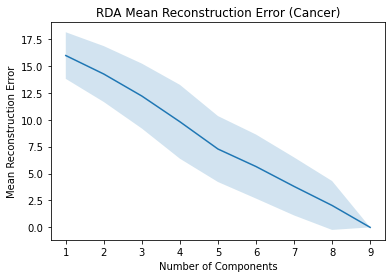

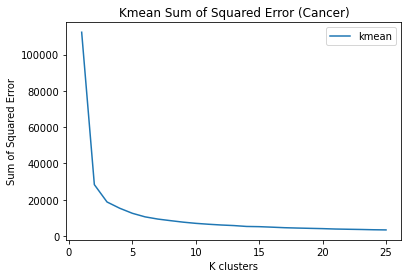

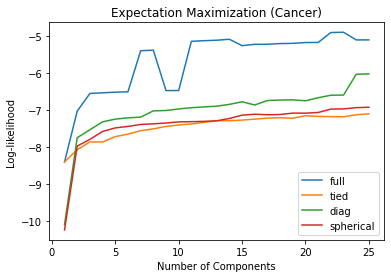

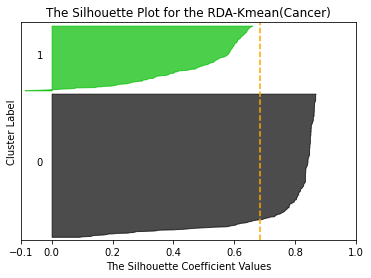

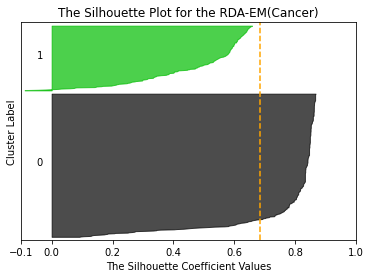

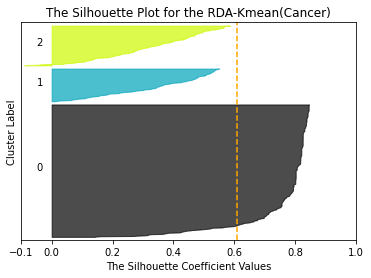

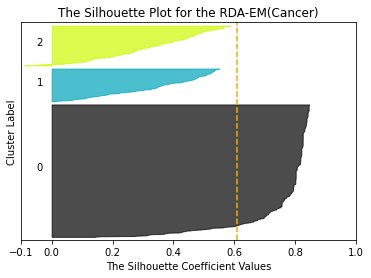

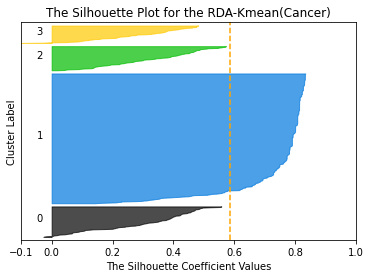

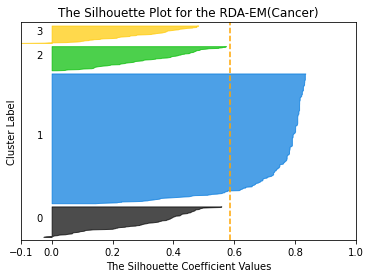

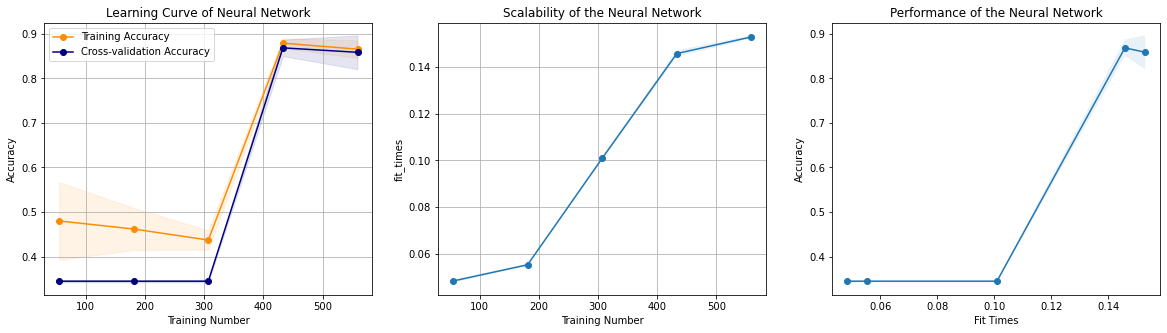

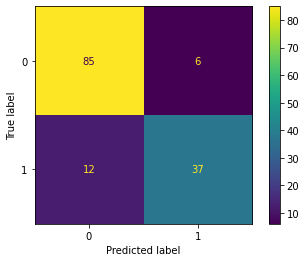

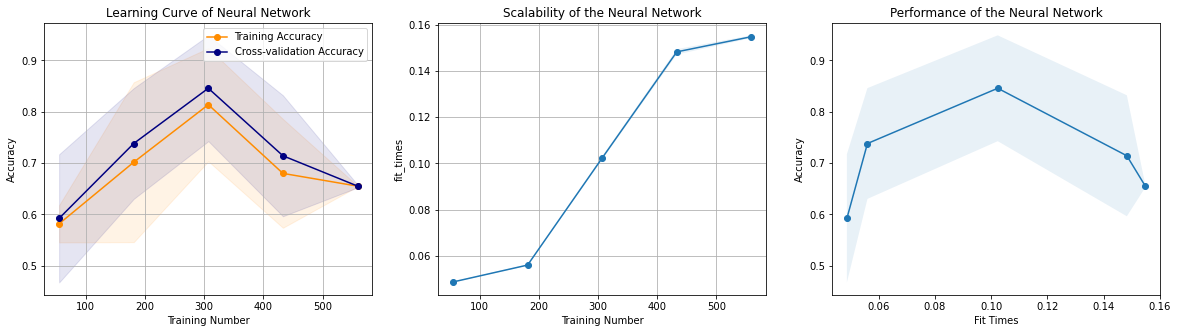

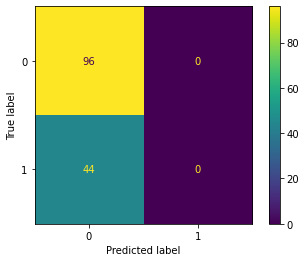

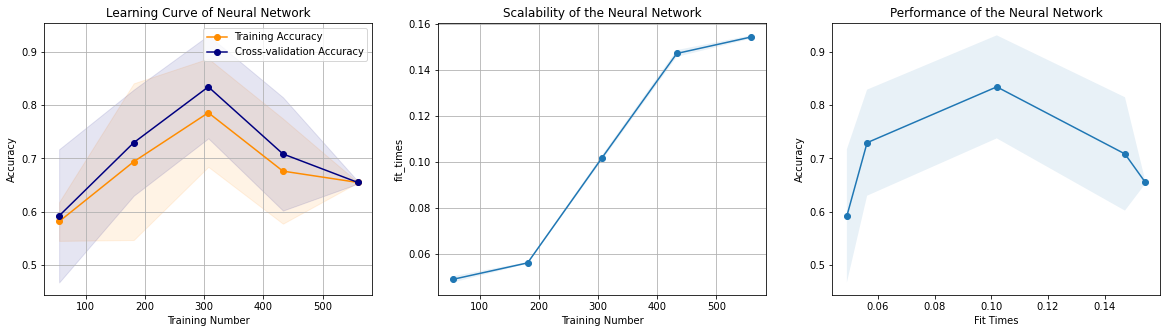

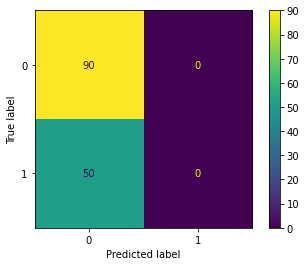

In [148]:
rd(df_x, df_y, range(50) ,'RDA', True)

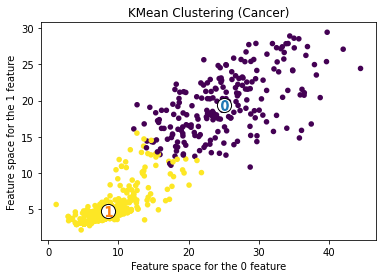

In [137]:
rda = GaussianRandomProjection(n_components=3, random_state=0)
reduce_x = rda.fit_transform(df_x)
cluster_plot(2, pd.DataFrame(reduce_x), 0, 1)

In [149]:
def tree(x, y, rang, file, cancer):
    feature_names = x_features
    rdc =  RandomForestClassifier(random_state=0)
    rdc = rdc.fit(x,y)
    importances = rdc.feature_importances_
    print(importances)
    std = np.std([rdc.feature_importances_ for rdc in rdc.estimators_], axis=0)
    
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature Importances using Mean Decrease in Impurity (Cancer)")
    ax.set_ylabel("Mean Decrease in Impurity")
    fig.tight_layout()
    
    select = SelectFromModel(rdc, prefit=True)
    reduce_x = select.transform(x)
    print(reduce_x,reduce_x.shape,'features')
    kmean(reduce_x,y, [i for i in range(1,26)], 'Tree-kmean-sse')
    em(reduce_x, y, [i for i in range(1,26)], 'Tree-EM-LL')
    for i in range(2,5):
        sil(i, reduce_x, True, 'Tree-Kmean')
        sil(i, reduce_x, False, 'Tree-EM')
    if cancer:
        X_train, X_test, Y_train, Y_test = train_test_split(reduce_x, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, reduce_x, y)
        new_x2 = dkmean(reduce_x, 2)
        new_x3 = dem(reduce_x, 2)
        x2 = combine(reduce_x, new_x2)
        x3 = combine(reduce_x, new_x3)
        X_train, X_test, Y_train, Y_test = train_test_split(x2, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, x2, y)
        X_train, X_test, Y_train, Y_test = train_test_split(x3, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test, x3, y)

[0.04878669 0.29507607 0.21341217 0.02766428 0.05777363 0.14806326
 0.14811681 0.05331935 0.00778774]
[[1 1 '1' 3]
 [4 4 '10' 3]
 [1 1 '2' 3]
 ...
 [10 10 '3' 8]
 [8 6 '4' 10]
 [8 8 '5' 10]] (699, 4) features
For n_clusters = 2 The average silhouette_score is : 0.678730693130398
For n_clusters = 2 The average silhouette_score is : 0.678730693130398
For n_clusters = 3 The average silhouette_score is : 0.6236537149911381
For n_clusters = 3 The average silhouette_score is : 0.6236537149911381
For n_clusters = 4 The average silhouette_score is : 0.6388957391802352
For n_clusters = 4 The average silhouette_score is : 0.6388957391802352
Precision:  0.0
Recall:  0.0
Accuracy:  0.65
Balanced Accuracy:  0.5
[[91  0]
 [49  0]]
Wall time:  0.15377187728881836
Precision:  0.92
Recall:  0.9583333333333334
Accuracy:  0.9571428571428572
Balanced Accuracy:  0.957427536231884
[[88  4]
 [ 2 46]]
Wall time:  0.15667510032653809
Precision:  0.9130434782608695
Recall:  0.9130434782608695
Accuracy:  0.94285

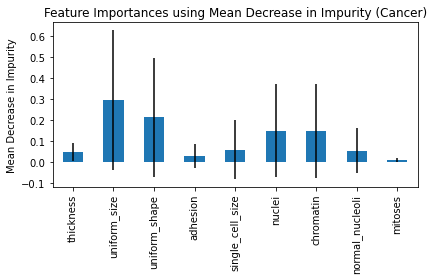

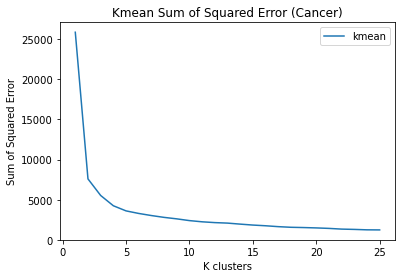

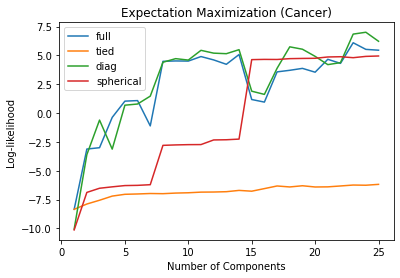

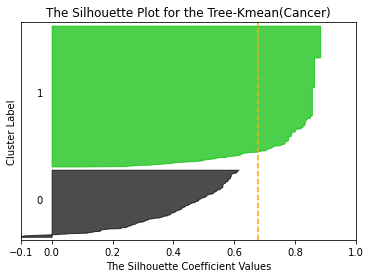

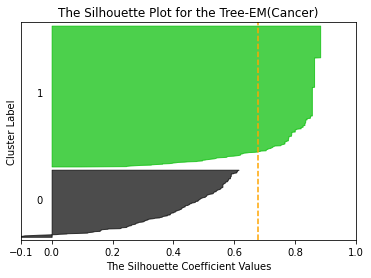

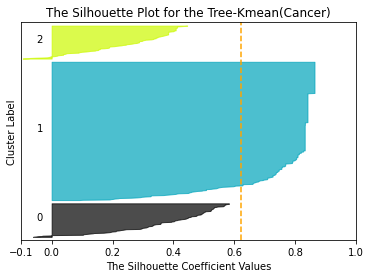

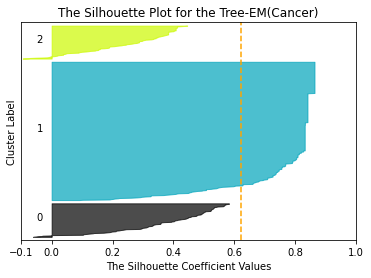

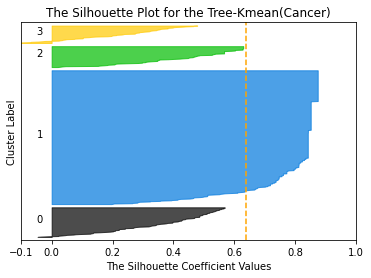

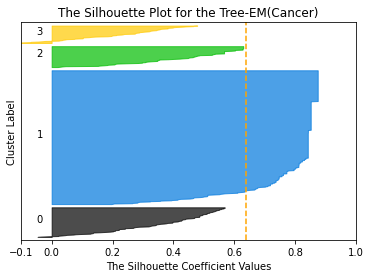

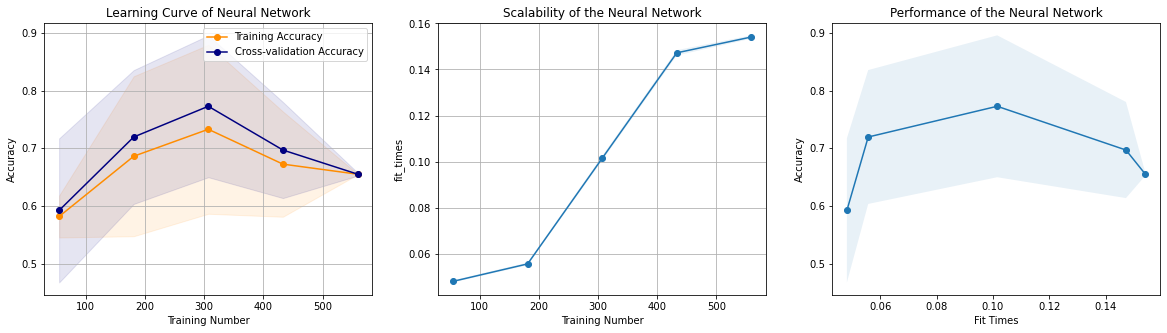

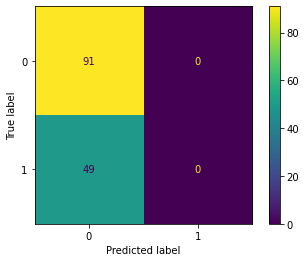

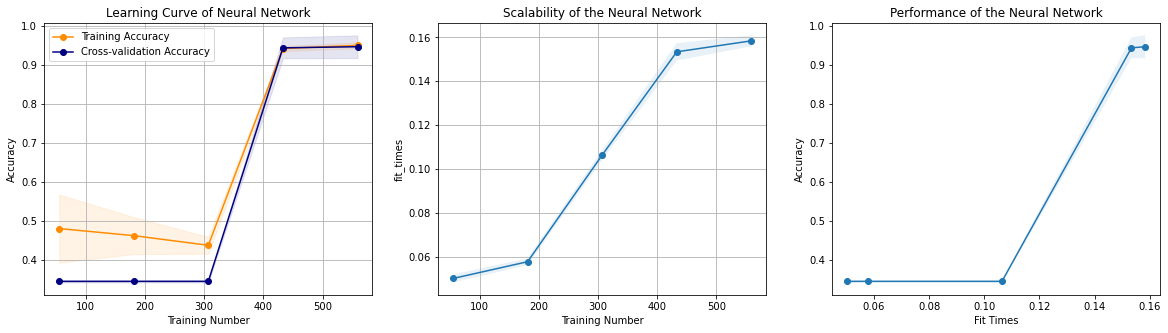

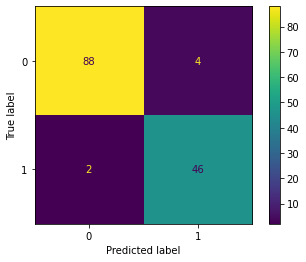

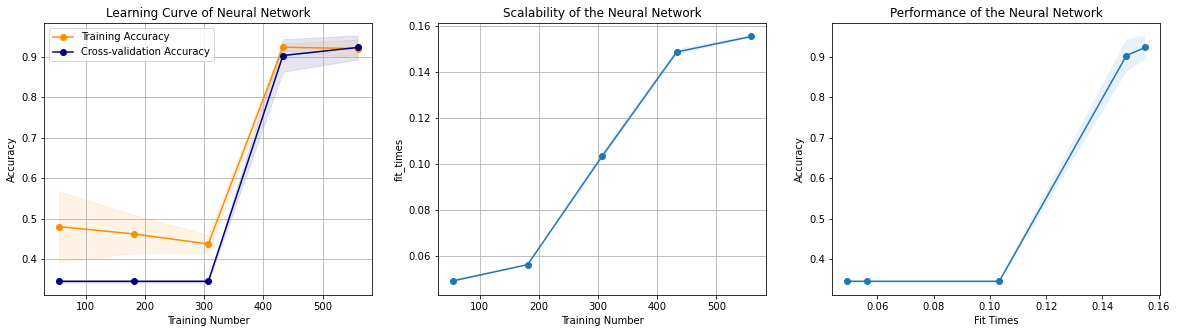

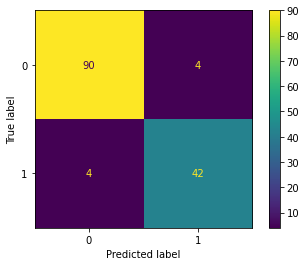

In [150]:
tree(df_x, df_y, range(1,26) ,'RDC', True)

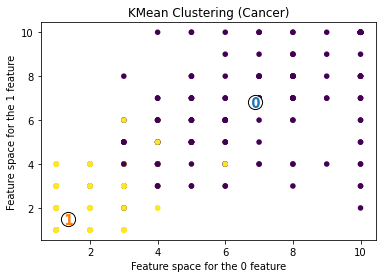

In [141]:
rdc =  RandomForestClassifier(random_state=0)
rdc = rdc.fit(df_x,df_y)
select = SelectFromModel(rdc, prefit=True)
reduce_x = select.transform(df_x)
cluster_plot(2, pd.DataFrame(reduce_x), 0, 1)